# Parameters

In [0]:
source_folder = '/content/drive/My Drive/COMP_4211_Project/Data/Phase_3'
destination_folder = '/content/drive/My Drive/COMP_4211_Project/Models/Phase_3'

# Libraries

In [0]:
!pip install sacremoses

In [0]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator
from torchtext.vocab import GloVe

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Preliminaries

In [0]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='moses', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('text', text_field)]

# TabularDataset

train, valid = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                     format='CSV', fields=fields, skip_header=True)
UV_train, UV_test = TabularDataset.splits(path=source_folder, train='UVictoria_train.csv', test='UVictoria_test.csv',
                                     format='CSV', fields=fields, skip_header=True)
LIAR_train, LIAR_valid, LIAR_test = TabularDataset.splits(path=source_folder,
                                                          train='LIAR_train.csv', validation='LIAR_valid.csv', test='LIAR_test.csv',
                                                          format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
UV_train_iter = BucketIterator(UV_train, batch_size=32, sort_key=lambda x: len(x.text),
                               device=device, sort=True, sort_within_batch=True)
UV_test_iter = BucketIterator(UV_test, batch_size=32, sort_key=lambda x: len(x.text),
                              device=device, sort=True, sort_within_batch=True)
LIAR_train_iter = BucketIterator(LIAR_train, batch_size=32, sort_key=lambda x: len(x.text),
                                 device=device, sort=True, sort_within_batch=True)
LIAR_valid_iter = BucketIterator(LIAR_valid, batch_size=32, sort_key=lambda x: len(x.text),
                                 device=device, sort=True, sort_within_batch=True)
LIAR_test_iter = BucketIterator(LIAR_test, batch_size=32, sort_key=lambda x: len(x.text),
                                device=device, sort=True, sort_within_batch=True)

# Vocabulary

if 'glove' not in globals():
    glove = GloVe(name='6B', dim=300)
text_field.build_vocab(train, min_freq=3, vectors=glove)

# Models

In [0]:
class OurEncoder(nn.Module):
    
    def __init__(self, dimension):
        super(OurEncoder, self).__init__()
        
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)
    
    def forward(self, text_emb, text_len):
        
        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)

        return self.drop(out_reduced)

In [0]:
class OurClassifier(nn.Module):

    def __init__(self, dimension):
        super(OurClassifier, self).__init__()

        self.fc = nn.Linear(dimension, 1)

    def forward(self, x):
        x = self.fc(x)
        x = torch.squeeze(x, 1)
        x = torch.sigmoid(x)

        return x

In [0]:
class GLOVE_Embedding(nn.Module):

    def __init__(self, dimension=300):
        super(GLOVE_Embedding, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), dimension)
        self.embedding.weight.data = text_field.vocab.vectors

    def forward(self, x):
        return self.embedding(x)

In [0]:
class GLOVE(nn.Module):

    def __init__(self, dimension=128):
        super(GLOVE, self).__init__()

        self.embedding = GLOVE_Embedding()
        self.encoder = OurEncoder(dimension)
        self.classifier = OurClassifier(2*dimension)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)
        text_fea = self.encoder(text_emb, text_len)
        text_out = self.classifier(text_fea)

        return text_out

# Pretraining

In [0]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [0]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf"),
          version = 'default'):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (text, text_len)), _ in train_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            
            output = model(text, text_len)
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (labels, (text, text_len)), _ in valid_loader:
                        labels = labels.to(device)
                        text = text.to(device)
                        text_len = text_len.to(device)
                        
                        output = model(text, text_len)
                        loss = criterion(output, labels)
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + version + '_model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/' + version + '_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + version + '_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [0]:
model = GLOVE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, version='GloVe')

Epoch [1/5], Step [79/790], Train Loss: 0.6182, Valid Loss: 0.3537
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_metrics.pt
Epoch [1/5], Step [158/790], Train Loss: 0.3584, Valid Loss: 0.2359
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_metrics.pt
Epoch [2/5], Step [237/790], Train Loss: 0.2600, Valid Loss: 0.2353
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_metrics.pt
Epoch [2/5], Step [316/790], Train Loss: 0.4496, Valid Loss: 0.2682
Epoch [3/5], Step [395/790], Train Loss: 0.2338, Valid Loss: 0.1920
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_model.pt
Model saved to ==>

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_metrics.pt


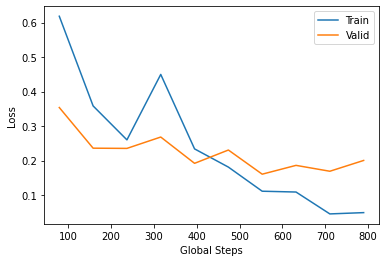

In [0]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/GloVe_metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

# Training and Evaluation

In [0]:
# Evaluation Function

def evaluate(model, test_loader, threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (text, text_len)), _ in test_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            
            output = model(text, text_len)
            output = (output > threshold).int()
            
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

## ISOT News Dataset

In [0]:
# Training Without Pretraining
model = GLOVE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, version='GloVe_Trained',
      train_loader = UV_train_iter, valid_loader = UV_train_iter,
      num_epochs=5, eval_every=len(UV_train_iter))

Epoch [1/5], Step [28/140], Train Loss: 0.5019, Valid Loss: 0.2113
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_Trained_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_Trained_metrics.pt
Epoch [2/5], Step [56/140], Train Loss: 0.1604, Valid Loss: 0.0886
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_Trained_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_Trained_metrics.pt
Epoch [3/5], Step [84/140], Train Loss: 0.0784, Valid Loss: 0.0487
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_Trained_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_Trained_metrics.pt
Epoch [4/5], Step [112/140], Train Loss: 0.0472, Valid Loss: 0.0391
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_Trained_model.pt
Model saved to ==> /content/driv

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_Trained_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9840    0.9383    0.9606     22285
           0     0.9376    0.9838    0.9601     20992

    accuracy                         0.9604     43277
   macro avg     0.9608    0.9611    0.9604     43277
weighted avg     0.9615    0.9604    0.9604     43277



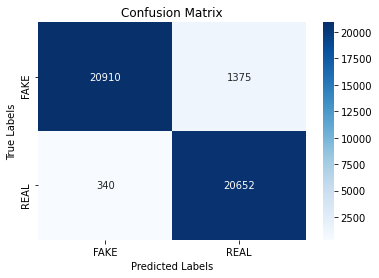

In [0]:
model = GLOVE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/GloVe_Trained_model.pt', model, optimizer)

evaluate(model, UV_test_iter)

In [0]:
# Training With Pretraining
model = GLOVE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/GloVe_model.pt', model, optimizer)

optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, version='GloVe_TrainedPretrained',
      train_loader = UV_train_iter, valid_loader = UV_train_iter,
      num_epochs=5, eval_every=len(UV_train_iter))

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_model.pt
Epoch [1/5], Step [28/140], Train Loss: 0.3471, Valid Loss: 0.1627
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_TrainedPretrained_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_TrainedPretrained_metrics.pt
Epoch [2/5], Step [56/140], Train Loss: 0.1272, Valid Loss: 0.0952
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_TrainedPretrained_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_TrainedPretrained_metrics.pt
Epoch [3/5], Step [84/140], Train Loss: 0.0742, Valid Loss: 0.0495
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_TrainedPretrained_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_TrainedPretrained_metrics.pt
Epoch [4/5], Step [112/140], Train Loss: 0.04

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_TrainedPretrained_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9756    0.9596    0.9675     22285
           0     0.9578    0.9745    0.9661     20992

    accuracy                         0.9668     43277
   macro avg     0.9667    0.9670    0.9668     43277
weighted avg     0.9670    0.9668    0.9668     43277



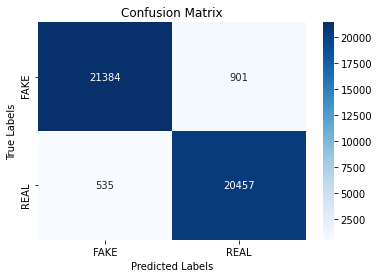

In [0]:
model = GLOVE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/GloVe_TrainedPretrained_model.pt', model, optimizer)

evaluate(model, UV_test_iter)

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8675    0.5201    0.6503     22285
           0     0.6425    0.9156    0.7551     20992

    accuracy                         0.7119     43277
   macro avg     0.7550    0.7179    0.7027     43277
weighted avg     0.7583    0.7119    0.7011     43277



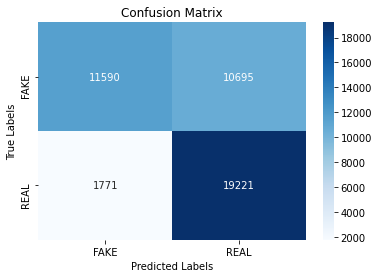

In [0]:
# Without Training
model = GLOVE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/GloVe_model.pt', model, optimizer)

evaluate(model, UV_test_iter)

## LIAR Dataset

In [0]:
# Training Without Pretraining
model = GLOVE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, version='GloVe_Trained_2',
      train_loader = LIAR_train_iter, valid_loader = LIAR_valid_iter,
      num_epochs=5, eval_every=len(LIAR_train_iter)//2)

Epoch [1/5], Step [91/910], Train Loss: 0.6860, Valid Loss: 0.6559
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_Trained_2_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_Trained_2_metrics.pt
Epoch [1/5], Step [182/910], Train Loss: 0.6665, Valid Loss: 0.6574
Epoch [2/5], Step [273/910], Train Loss: 0.6313, Valid Loss: 0.6318
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_Trained_2_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_Trained_2_metrics.pt
Epoch [2/5], Step [364/910], Train Loss: 0.6113, Valid Loss: 0.6681
Epoch [3/5], Step [455/910], Train Loss: 0.5450, Valid Loss: 0.6508
Epoch [3/5], Step [546/910], Train Loss: 0.4918, Valid Loss: 0.7903
Epoch [4/5], Step [637/910], Train Loss: 0.4083, Valid Loss: 0.7602
Epoch [4/5], Step [728/910], Train Loss: 0.3019, Valid Loss: 0.8764
Epoch [5/5], Step [819/910], Train Loss: 0.2472, 

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_Trained_2_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.6328    0.5421    0.5840       356
           0     0.6753    0.7517    0.7114       451

    accuracy                         0.6592       807
   macro avg     0.6540    0.6469    0.6477       807
weighted avg     0.6565    0.6592    0.6552       807



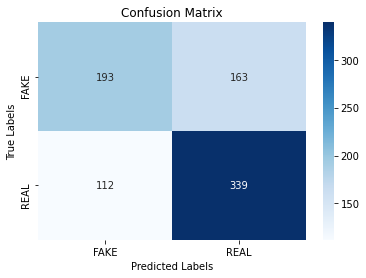

In [0]:
model = GLOVE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/GloVe_Trained_2_model.pt', model, optimizer)

evaluate(model, LIAR_test_iter)

In [0]:
# Training With Pretraining
model = GLOVE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/GloVe_model.pt', model, optimizer)

optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, version='GloVe_TrainedPretrained_2',
      train_loader = LIAR_train_iter, valid_loader = LIAR_valid_iter,
      num_epochs=5, eval_every=len(LIAR_train_iter)//2)

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_model.pt
Epoch [1/5], Step [91/910], Train Loss: 0.8119, Valid Loss: 0.6690
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_TrainedPretrained_2_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_TrainedPretrained_2_metrics.pt
Epoch [1/5], Step [182/910], Train Loss: 0.7094, Valid Loss: 0.6624
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_TrainedPretrained_2_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_TrainedPretrained_2_metrics.pt
Epoch [2/5], Step [273/910], Train Loss: 0.6569, Valid Loss: 0.6426
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_TrainedPretrained_2_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_TrainedPretrained_2_metrics.pt
Epoch [2/5], Step [364/910], Tr

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_TrainedPretrained_2_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.6574    0.5337    0.5891       356
           0     0.6795    0.7805    0.7265       451

    accuracy                         0.6716       807
   macro avg     0.6685    0.6571    0.6578       807
weighted avg     0.6698    0.6716    0.6659       807



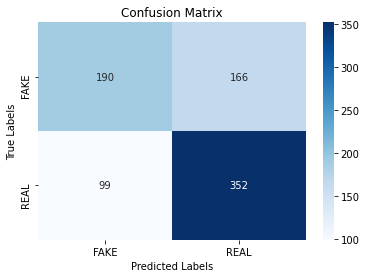

In [0]:
model = GLOVE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/GloVe_TrainedPretrained_2_model.pt', model, optimizer)

evaluate(model, LIAR_test_iter)

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_3/GloVe_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.5479    0.2247    0.3187       356
           0     0.5825    0.8537    0.6924       451

    accuracy                         0.5762       807
   macro avg     0.5652    0.5392    0.5056       807
weighted avg     0.5672    0.5762    0.5276       807



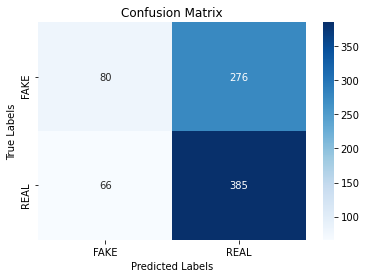

In [0]:
# Without Training
model = GLOVE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/GloVe_model.pt', model, optimizer)

evaluate(model, LIAR_test_iter)